In [2]:
import torch
import numpy as np
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
from matplotlib import pyplot as plt

In [4]:
import torch.nn.functional as F

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,),(0.5,)),
                              ])

In [6]:
trainset= datasets.CIFAR10('~/.pytorch/CIFAR10_data/', train=True, download=True, transform=transform)

validset= datasets.CIFAR10('~/.pytorch/CIFAR10_data/', train=True, download=True, transform=transform)

testset= datasets.CIFAR10('~/.pytorch/CIFAR10_data/', train=False, download=True,transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
num_train = len(trainset)
num_test = len(testset)
indices = list(range(num_train))
split = int(np.floor(0.3 * num_train))

np.random.seed(42)
np.random.shuffle(indices)
batch_size = 100
pin_memory = 1
num_workers = 1

In [8]:
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, sampler=train_sampler,
    num_workers=num_workers, pin_memory=pin_memory,
)
valid_loader = torch.utils.data.DataLoader(
    validset, batch_size=batch_size, sampler=valid_sampler,
    num_workers=num_workers, pin_memory=pin_memory,
)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, num_workers=num_workers, 
    pin_memory=pin_memory, shuffle=True
)

In [9]:
for imgs,labels in test_loader:
    print(imgs.shape,labels.shape)
    break

torch.Size([100, 3, 32, 32]) torch.Size([100])


## 1 CNN, 1 BNorm, 1 Dense

In [10]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(3,10,kernel_size=3,padding=1)
        self.bnorm1 = nn.BatchNorm2d(10)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dense1 = nn.Linear(10*16*16,10)
    def forward(self,x):
        out = self.cnn1(x)
        out = self.bnorm1(out)
        out = self.maxpool1(out)
        
        out = out.view(out.shape[0],-1)
        
        out = self.dense1(out)
#         out = F.softmax(out)
        
        return out
        
        

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
CNN = CNNModel().to(device)

In [13]:
lr = 0.001
optimizer = optim.SGD(CNN.parameters(),lr= lr,momentum=0.6)
criterion = nn.CrossEntropyLoss()

In [14]:
epochs = 25
iter_n = 0

In [15]:
for e in range(epochs):
    iter_n = 0
    print("Epoch %d of %d"%(e+1,epochs))
    for imgs,labels in train_loader:
        
        imgs = imgs.to(device)
        labels = labels.to(device)
#         print(imgs.shape)
        optimizer.zero_grad()
        
        preds = CNN(imgs)
        loss = criterion(preds,labels)
        
        loss.backward()
        optimizer.step()
        
        iter_n+=1
#         print(iter_n)
        if iter_n % 175 == 0:
            total = 0
            correct = 0
            
            for imgs,labels in valid_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                
                preds = CNN(imgs)
                outputs = torch.argmax(preds.data,1)
                
                total += imgs.shape[0]
                
                correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
                
                if total>= 50:
                    break
            accuracy = correct/total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter_n, loss.item(), accuracy))
                
        

Epoch 1 of 25
Iteration: 175. Loss: 1.9514120817184448. Accuracy: 34.0
Iteration: 350. Loss: 1.6736445426940918. Accuracy: 44.0
Epoch 2 of 25
Iteration: 175. Loss: 1.6885426044464111. Accuracy: 40.0
Iteration: 350. Loss: 1.6934655904769897. Accuracy: 38.0
Epoch 3 of 25
Iteration: 175. Loss: 1.531061053276062. Accuracy: 40.0
Iteration: 350. Loss: 1.5542184114456177. Accuracy: 45.0
Epoch 4 of 25
Iteration: 175. Loss: 1.5590788125991821. Accuracy: 53.0
Iteration: 350. Loss: 1.6739698648452759. Accuracy: 51.0
Epoch 5 of 25
Iteration: 175. Loss: 1.3293052911758423. Accuracy: 43.0
Iteration: 350. Loss: 1.60245943069458. Accuracy: 48.0
Epoch 6 of 25
Iteration: 175. Loss: 1.3968756198883057. Accuracy: 55.0
Iteration: 350. Loss: 1.5265984535217285. Accuracy: 40.0
Epoch 7 of 25
Iteration: 175. Loss: 1.4167370796203613. Accuracy: 61.0
Iteration: 350. Loss: 1.4756475687026978. Accuracy: 45.0
Epoch 8 of 25
Iteration: 175. Loss: 1.153502345085144. Accuracy: 52.0
Iteration: 350. Loss: 1.2677546739578

In [16]:
total = 0
correct = 0
for imgs,labels in valid_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    preds = CNN(imgs)
    outputs = torch.argmax(preds.data,1)

    total += imgs.shape[0]

    correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
accuracy = correct/total
print('Accuracy: {}'.format(accuracy))


Accuracy: 58.70000076293945


In [17]:
total = 0
correct = 0
for imgs,labels in train_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    preds = CNN(imgs)
    outputs = torch.argmax(preds.data,1)

    total += imgs.shape[0]

    correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
accuracy = correct/total
print('Training Accuracy: {}'.format(accuracy))


Training Accuracy: 64.67428588867188


## 1 CNN, 0 BNorm, 1 Dense

In [18]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(3,10,kernel_size=3,padding=1)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dense1 = nn.Linear(10*16*16,10)
    def forward(self,x):
        out = self.cnn1(x)
        out = self.maxpool1(out)
        
        out = out.view(out.shape[0],-1)
        
        out = self.dense1(out)
#         out = F.softmax(out)
        
        return out
        
        

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
CNN = CNNModel().to(device)

In [21]:
lr = 0.001
optimizer = optim.SGD(CNN.parameters(),lr= lr,momentum=0.6)
criterion = nn.CrossEntropyLoss()

In [22]:
epochs = 25
iter_n = 0

In [23]:
for e in range(epochs):
    iter_n = 0
    print("Epoch %d of %d"%(e+1,epochs))
    for imgs,labels in train_loader:
        
        imgs = imgs.to(device)
        labels = labels.to(device)
#         print(imgs.shape)
        optimizer.zero_grad()
        
        preds = CNN(imgs)
        loss = criterion(preds,labels)
        
        loss.backward()
        optimizer.step()
        
        iter_n+=1
#         print(iter_n)
        if iter_n % 175 == 0:
            total = 0
            correct = 0
            
            for imgs,labels in valid_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                
                preds = CNN(imgs)
                outputs = torch.argmax(preds.data,1)
                
                total += imgs.shape[0]
                
                correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
                
                if total>= 50:
                    break
            accuracy = correct/total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter_n, loss.item(), accuracy))
                
        

Epoch 1 of 25
Iteration: 175. Loss: 2.124326705932617. Accuracy: 28.0
Iteration: 350. Loss: 1.9787156581878662. Accuracy: 33.0
Epoch 2 of 25
Iteration: 175. Loss: 2.013085126876831. Accuracy: 39.0
Iteration: 350. Loss: 1.9163126945495605. Accuracy: 32.0
Epoch 3 of 25
Iteration: 175. Loss: 1.774092197418213. Accuracy: 33.0
Iteration: 350. Loss: 1.7162063121795654. Accuracy: 40.0
Epoch 4 of 25
Iteration: 175. Loss: 1.7078090906143188. Accuracy: 46.0
Iteration: 350. Loss: 1.845811367034912. Accuracy: 44.0
Epoch 5 of 25
Iteration: 175. Loss: 1.7281628847122192. Accuracy: 40.0
Iteration: 350. Loss: 1.7075647115707397. Accuracy: 43.0
Epoch 6 of 25
Iteration: 175. Loss: 1.7761001586914062. Accuracy: 33.0
Iteration: 350. Loss: 1.8249270915985107. Accuracy: 56.0
Epoch 7 of 25
Iteration: 175. Loss: 1.672524094581604. Accuracy: 42.0
Iteration: 350. Loss: 1.5903080701828003. Accuracy: 38.0
Epoch 8 of 25
Iteration: 175. Loss: 1.6998672485351562. Accuracy: 43.0
Iteration: 350. Loss: 1.70916402339935

In [24]:
total = 0
correct = 0
for imgs,labels in valid_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    preds = CNN(imgs)
    outputs = torch.argmax(preds.data,1)

    total += imgs.shape[0]

    correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
accuracy = correct/total
print('Accuracy: {}'.format(accuracy))


Accuracy: 51.186668395996094


In [25]:
total = 0
correct = 0
for imgs,labels in train_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    preds = CNN(imgs)
    outputs = torch.argmax(preds.data,1)

    total += imgs.shape[0]

    correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
accuracy = correct/total
print('Training Accuracy: {}'.format(accuracy))


Training Accuracy: 52.702857971191406


## 1 CNN, 1 BNorm, 2 Dense

In [26]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(3,10,kernel_size=3,padding=1)
        self.bnorm1 = nn.BatchNorm2d(10)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dense1 = nn.Linear(10*16*16,64)
        self.dense2 = nn.Linear(64,10)
    def forward(self,x):
        out = self.cnn1(x)
        out = self.bnorm1(out)
        out = self.maxpool1(out)
        
        out = out.view(out.shape[0],-1)
        
        out = F.relu(self.dense1(out))
        out = self.dense2(out)
#         out = F.softmax(out)
        
        return out
        
        

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [28]:
CNN = CNNModel().to(device)

In [29]:
lr = 0.001
optimizer = optim.SGD(CNN.parameters(),lr= lr,momentum=0.6)
criterion = nn.CrossEntropyLoss()

In [30]:
epochs = 25
iter_n = 0

In [31]:
for e in range(epochs):
    iter_n = 0
    print("Epoch %d of %d"%(e+1,epochs))
    for imgs,labels in train_loader:
        
        imgs = imgs.to(device)
        labels = labels.to(device)
#         print(imgs.shape)
        optimizer.zero_grad()
        
        preds = CNN(imgs)
        loss = criterion(preds,labels)
        
        loss.backward()
        optimizer.step()
        
        iter_n+=1
#         print(iter_n)
        if iter_n % 175 == 0:
            total = 0
            correct = 0
            
            for imgs,labels in valid_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                
                preds = CNN(imgs)
                outputs = torch.argmax(preds.data,1)
                
                total += imgs.shape[0]
                
                correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
                
                if total>= 50:
                    break
            accuracy = correct/total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter_n, loss.item(), accuracy))
                
        

Epoch 1 of 25
Iteration: 175. Loss: 2.023902416229248. Accuracy: 25.0
Iteration: 350. Loss: 1.8540083169937134. Accuracy: 34.0
Epoch 2 of 25
Iteration: 175. Loss: 1.7243174314498901. Accuracy: 42.0
Iteration: 350. Loss: 1.6832270622253418. Accuracy: 41.0
Epoch 3 of 25
Iteration: 175. Loss: 1.773441195487976. Accuracy: 53.0
Iteration: 350. Loss: 1.5154191255569458. Accuracy: 45.0
Epoch 4 of 25
Iteration: 175. Loss: 1.5528068542480469. Accuracy: 46.0
Iteration: 350. Loss: 1.4188392162322998. Accuracy: 60.0
Epoch 5 of 25
Iteration: 175. Loss: 1.4498469829559326. Accuracy: 57.0
Iteration: 350. Loss: 1.51395583152771. Accuracy: 49.0
Epoch 6 of 25
Iteration: 175. Loss: 1.5980825424194336. Accuracy: 47.0
Iteration: 350. Loss: 1.4037319421768188. Accuracy: 45.0
Epoch 7 of 25
Iteration: 175. Loss: 1.406535029411316. Accuracy: 46.0
Iteration: 350. Loss: 1.347397804260254. Accuracy: 46.0
Epoch 8 of 25
Iteration: 175. Loss: 1.3898385763168335. Accuracy: 49.0
Iteration: 350. Loss: 1.286856532096862

In [32]:
total = 0
correct = 0
for imgs,labels in valid_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    preds = CNN(imgs)
    outputs = torch.argmax(preds.data,1)

    total += imgs.shape[0]

    correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
accuracy = correct/total
print('Accuracy: {}'.format(accuracy))


Accuracy: 61.393333435058594


In [33]:
total = 0
correct = 0
for imgs,labels in train_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    preds = CNN(imgs)
    outputs = torch.argmax(preds.data,1)

    total += imgs.shape[0]

    correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
accuracy = correct/total
print('Training Accuracy: {}'.format(accuracy))


Training Accuracy: 67.55714416503906


## 2 CNN, 1 BNorm, 1 Dense

In [34]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(3,10,kernel_size=3,padding=1)
        self.cnn2 = nn.Conv2d(10,20,kernel_size=3,padding=1)
        self.bnorm1 = nn.BatchNorm2d(20)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dense1 = nn.Linear(20*16*16,10)
    def forward(self,x):
        out = self.cnn1(x)
        out = self.cnn2(out)
        out = self.bnorm1(out)
        out = self.maxpool1(out)
        
        out = out.view(out.shape[0],-1)
        
        out = self.dense1(out)
#         out = F.softmax(out)
        
        return out
        
        

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [36]:
CNN = CNNModel().to(device)

In [37]:
lr = 0.001
optimizer = optim.SGD(CNN.parameters(),lr= lr,momentum=0.6)
criterion = nn.CrossEntropyLoss()

In [38]:
epochs = 25
iter_n = 0
iter_total = 0
stats_list = list()

In [39]:
for e in range(epochs):
    iter_n = 0
    print("Epoch %d of %d"%(e+1,epochs))
    for imgs,labels in train_loader:
        
        imgs = imgs.to(device)
        labels = labels.to(device)
#         print(imgs.shape)
        optimizer.zero_grad()
        
        preds = CNN(imgs)
        loss = criterion(preds,labels)
        
        loss.backward()
        optimizer.step()
        
        iter_n+=1
        iter_total += 1
#         print(iter_n)
        if iter_n % 175 == 0:
            total = 0
            correct = 0
            
            for imgs,labels in valid_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                
                preds = CNN(imgs)
                outputs = torch.argmax(preds.data,1)
                test_loss = criterion(preds,labels)
                total += imgs.shape[0]
                
                correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
                
                if total>= 50:
                    break
            accuracy = correct/total
            correct = 0
            total = 0
            for imgs,labels in train_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                
                preds = CNN(imgs)
                outputs = torch.argmax(preds.data,1)
                train_loss = criterion(preds,labels)
                total += imgs.shape[0]
                
                correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
                
                if total>= 50:
                    break
            train_acc = correct/total
            if iter_n%350 == 0:
                stats_list.append([train_acc,accuracy,train_loss,test_loss])
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter_n, loss.item(), accuracy))
                
        

Epoch 1 of 25
Iteration: 175. Loss: 1.6239798069000244. Accuracy: 31.0
Iteration: 350. Loss: 1.701645016670227. Accuracy: 35.0
Epoch 2 of 25
Iteration: 175. Loss: 1.4557839632034302. Accuracy: 49.0
Iteration: 350. Loss: 1.7034544944763184. Accuracy: 49.0
Epoch 3 of 25
Iteration: 175. Loss: 1.5431945323944092. Accuracy: 48.0
Iteration: 350. Loss: 1.2970494031906128. Accuracy: 56.0
Epoch 4 of 25
Iteration: 175. Loss: 1.2917627096176147. Accuracy: 47.0
Iteration: 350. Loss: 1.3724523782730103. Accuracy: 56.0
Epoch 5 of 25
Iteration: 175. Loss: 1.1539332866668701. Accuracy: 56.0
Iteration: 350. Loss: 1.1712507009506226. Accuracy: 62.0
Epoch 6 of 25
Iteration: 175. Loss: 1.1930333375930786. Accuracy: 48.0
Iteration: 350. Loss: 1.1797661781311035. Accuracy: 51.0
Epoch 7 of 25
Iteration: 175. Loss: 1.3225159645080566. Accuracy: 57.0
Iteration: 350. Loss: 1.0321884155273438. Accuracy: 62.0
Epoch 8 of 25
Iteration: 175. Loss: 1.1002166271209717. Accuracy: 61.0
Iteration: 350. Loss: 1.2034785747

In [40]:
total = 0
correct = 0
for imgs,labels in valid_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    preds = CNN(imgs)
    outputs = torch.argmax(preds.data,1)

    total += imgs.shape[0]

    correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
accuracy = correct/total
print('Accuracy: {}'.format(accuracy))


Accuracy: 63.573333740234375


In [41]:
total = 0
correct = 0
for imgs,labels in train_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    preds = CNN(imgs)
    outputs = torch.argmax(preds.data,1)

    total += imgs.shape[0]

    correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
accuracy = correct/total
print('Training Accuracy: {}'.format(accuracy))


Training Accuracy: 73.82286071777344


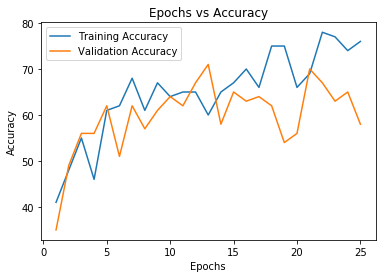

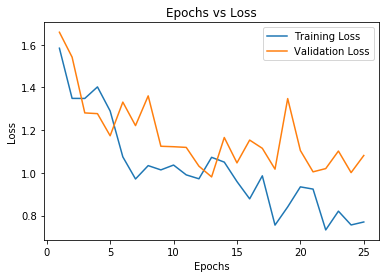

In [42]:
stats_np = np.array(stats_list)
plt.figure()
plt.plot(list(range(1,stats_np.shape[0]+1)),stats_np[:,0],label = "Training Accuracy",)
plt.plot(list(range(1,stats_np.shape[0]+1)),stats_np[:,1],label = "Validation Accuracy")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Epochs vs Accuracy")
plt.show()

plt.figure()
plt.plot(list(range(1,stats_np.shape[0]+1)),stats_np[:,2],label = "Training Loss",)
plt.plot(list(range(1,stats_np.shape[0]+1)),stats_np[:,3],label = "Validation Loss")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Epochs vs Loss")
plt.show()

In [43]:
CNN

CNNModel(
  (cnn1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=5120, out_features=10, bias=True)
)

In [44]:
torch.save(CNN.state_dict(), 'q1.pth')

In [46]:
total = 0
correct = 0
for imgs,labels in test_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    preds = CNN(imgs)
    outputs = torch.argmax(preds.data,1)

    total += imgs.shape[0]

    correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
accuracy = correct/total
print('Test Accuracy: {}'.format(accuracy))


Test Accuracy: 62.47999954223633
